# Single label Classifier - AF Detection

Using the dataset provided by the 2020 Physionet Challenge we've developed an Atrial Fibrilation Detector trained to identify AF diagnosed patients from a dataset containing patients with different pathologies like: PAC, RBBB, I-AVB, PVC, LBBB, STD, STE and healthy individuals.

Although data from 12-lead ECG was provided, for this first analysis we've only used the lead 2 data and we've processed the signals in order to create a dataframe consisting of features we believe will help us classify.


In [1]:
import sys
import os
import subprocess
from urllib.parse import urlparse

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from IPython.display import display

from scipy.cluster import hierarchy as hc
from sklearn import metrics
from sklearn.metrics import f1_score, fbeta_score, make_scorer, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

import mlflow
import mlflow.sklearn

%matplotlib inline
import plotly.express as px
import seaborn as sns

In [2]:
experiment_id = mlflow.set_experiment('features_definitivas')

In [3]:
subprocess.run('rm -rf mlruns/.trash/*', shell=True, check=True)

CompletedProcess(args='rm -rf mlruns/.trash/*', returncode=0)

In [4]:
lead = 'HRV-lead2'
df_raw = pd.read_feather('datasets/phys-raw-lead2-HRV-eda')
df_raw.columns

Index(['HRV_RMSSD', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_SDSD', 'HRV_pNN50',
       'HRV_pNN20', 'HRV_HTI', 'var_P_time', 'var_P_peaks', 'age', 'label'],
      dtype='object')

### Data checks

In [5]:
labels = pd.get_dummies(df_raw['label'])
labels.describe()

,AF,Non-AF
count,6201.000000,6201.000000
mean,0.168037,0.831963
std,0.373930,0.373930
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,1.000000,1.000000


## Split between Train and Validation Datasets

### Training (80%) - Evaluation (20%)

In [6]:
y = df_raw['label'].copy()
X = df_raw.drop('label', axis=1)
X_train, X_eval, ytrain, yeval = train_test_split(X, y, test_size=0.2, random_state=42)
ytrain[:5]

286         AF
1820    Non-AF
307     Non-AF
4384    Non-AF
4822    Non-AF
Name: label, dtype: object

### Label encoding
'AF' as 1 and 'Non-AF' as 0

In [7]:
y_eval = label_binarize(yeval, classes=['Non-AF', 'AF'])
y_train = label_binarize(ytrain, classes=['Non-AF', 'AF'])
y_train[:5]

array([[1],
       [0],
       [0],
       [0],
       [0]])

## Evaluation Metrics

This are the evaluation metrics we are actually interested in.

In [8]:
res = pd.DataFrame({'model':[], 'auc':[]})

## Model Experiments

In [9]:
models = {
        'Logistic Regression': LogisticRegression(max_iter = 2000, n_jobs = 4, random_state=42),
        'Random Forest': RandomForestClassifier(n_jobs = 4, random_state=42),
        'SVC': SVC(random_state=42),
        'KNNeighbors': KNeighborsClassifier(n_jobs = 4)
}

#scorer = make_scorer(f1_score, pos_label='AF')

In [10]:
for name, model in models.items():
    
    # Model training with cross validation
    scores = cross_val_score(model, X_train, y_train, cv=4, scoring='roc_auc', n_jobs=4)
    
    # Save the results to a dataframe
    res = res.append({'model': f"{name}", 'auc': scores.mean()}, ignore_index=True)
    
    # Experiment Tracking
    with mlflow.start_run(experiment_id=experiment_id):
        mlflow.log_param("model", f"{name}")
        mlflow.log_param("features", "None")
        mlflow.log_param("lead", lead)
        mlflow.log_param("columns", list(X.columns))
        mlflow.log_param("number columns", len(list(X_train.columns)))
        mlflow.log_metric("auc", scores.mean())
        
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry
        if tracking_url_type_store != "file":

            mlflow.sklearn.log_model(model, "model", registered_model_name="AF_Classifier")
        
        else:
            
            mlflow.sklearn.log_model(model, "model")

In [11]:
res.sort_values('auc', ascending=False)

,model,auc
1,Random Forest,0.982302
0,Logistic Regression,0.971947
2,SVC,0.938123
3,KNNeighbors,0.931548


### Let's try some Scalers

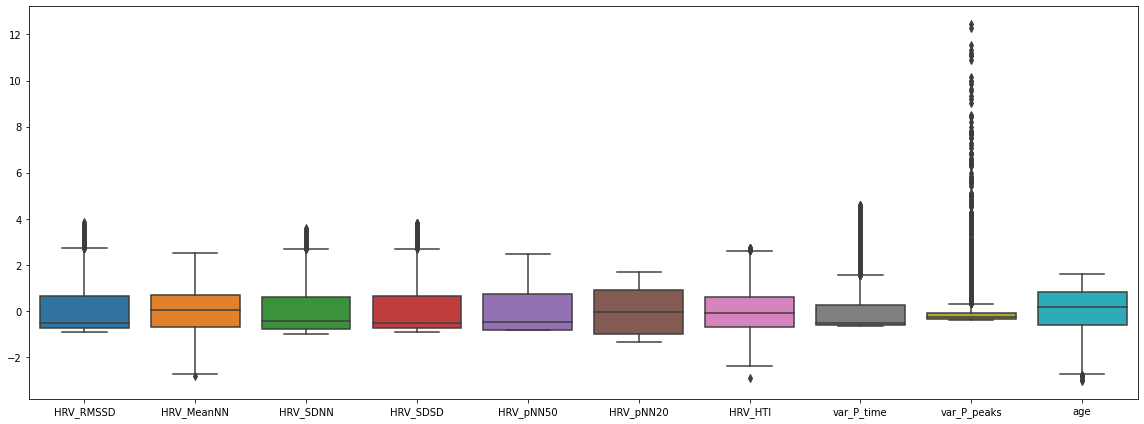

In [12]:
scal = StandardScaler()
df_normal = scal.fit_transform(df_raw.drop('label', axis=1))
cols = df_raw.columns
cols = cols.drop('label')
df_normal = pd.DataFrame(df_normal, columns=cols)

plt.figure(figsize=(16,6))
sns.boxplot(data=df_normal)
plt.tight_layout()
plt.show()

In [13]:
scal = StandardScaler()
xtrain_scal = scal.fit_transform(X_train)
xeval_scal = scal.transform(X_eval)

In [14]:
for name, model in models.items():
    scores = cross_val_score(model, xtrain_scal, y_train, cv=4, scoring='roc_auc', n_jobs=4)
    res = res.append({'model': f"{name} Scal", 'auc': scores.mean()}, ignore_index=True)
    
    # Experiment Tracking
    with mlflow.start_run(experiment_id=experiment_id):
        mlflow.log_param("model", f"{name}")
        mlflow.log_param("features", "Standard Scaler")
        mlflow.log_param("lead", lead)
        mlflow.log_param("columns", list(X.columns))
        mlflow.log_param("number columns", len(list(X_train.columns)))
        mlflow.log_metric("auc", scores.mean())
        
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        if tracking_url_type_store != "file":

            mlflow.sklearn.log_model(model, "model", registered_model_name="AF_Classifier")
        
        else:
            
            mlflow.sklearn.log_model(model, "model")

In [15]:
res.sort_values('auc', ascending=False)

,model,auc
5,Random Forest Scal,0.982335
1,Random Forest,0.982302
6,SVC Scal,0.974193
0,Logistic Regression,0.971947
4,Logistic Regression Scal,0.971881
7,KNNeighbors Scal,0.962041
2,SVC,0.938123
3,KNNeighbors,0.931548


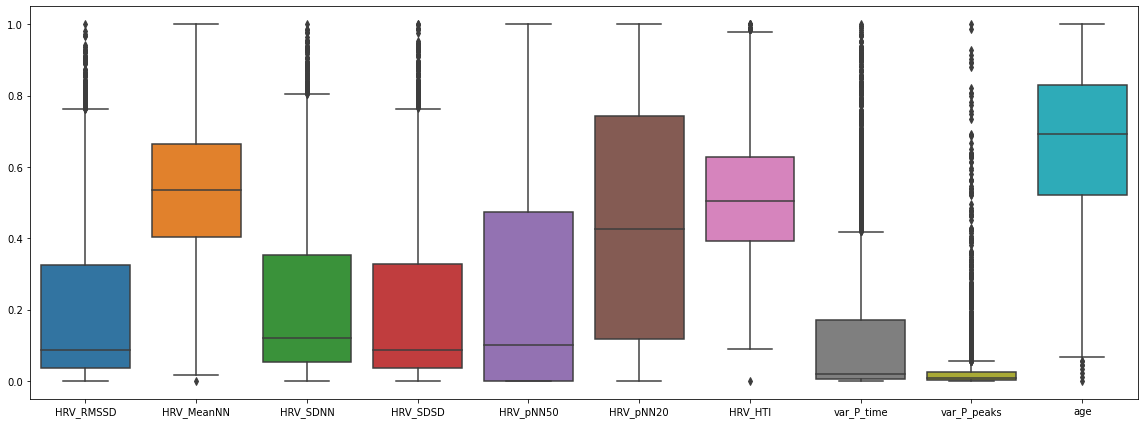

In [16]:
scal = MinMaxScaler()
df_normal = scal.fit_transform(df_raw.drop('label', axis=1))
cols = df_raw.columns
cols = cols.drop('label')
df_normal = pd.DataFrame(df_normal, columns=cols)

plt.figure(figsize=(16,6))
sns.boxplot(data=df_normal)
plt.tight_layout()
plt.show()

In [17]:
scal = MinMaxScaler()
xtrain_minmax = scal.fit_transform(X_train)
xeval_minmax = scal.transform(X_eval)

In [18]:
for name, model in models.items():
    scores = cross_val_score(model, xtrain_scal, y_train, cv=4, scoring='roc_auc', n_jobs=4)
    res = res.append({'model': f"{name} MinMax", 'auc': scores.mean()}, ignore_index=True)
    
    # Experiment Tracking
    with mlflow.start_run(experiment_id=experiment_id):
        mlflow.log_param("model", f"{name}")
        mlflow.log_param("features", "MinMax Scaler")
        mlflow.log_param("lead", lead)
        mlflow.log_param("columns", list(X.columns))
        mlflow.log_param("number columns", len(list(X_train.columns)))
        mlflow.log_metric("auc", scores.mean())
        
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        if tracking_url_type_store != "file":

            mlflow.sklearn.log_model(model, "model", registered_model_name="AF_Classifier")
        
        else:
            
            mlflow.sklearn.log_model(model, "model")

In [19]:
res.sort_values('auc', ascending=False)

,model,auc
5,Random Forest Scal,0.982335
9,Random Forest MinMax,0.982335
1,Random Forest,0.982302
6,SVC Scal,0.974193
10,SVC MinMax,0.974193
0,Logistic Regression,0.971947
4,Logistic Regression Scal,0.971881
8,Logistic Regression MinMax,0.971881
7,KNNeighbors Scal,0.962041
11,KNNeighbors MinMax,0.962041


### Principal Component Analysis

In [20]:
n_comps = 4  # 90% explained variance

pca = PCA(n_components = n_comps)

train_pca = pca.fit_transform(xtrain_scal)

eval_pca = pca.transform(xeval_scal)

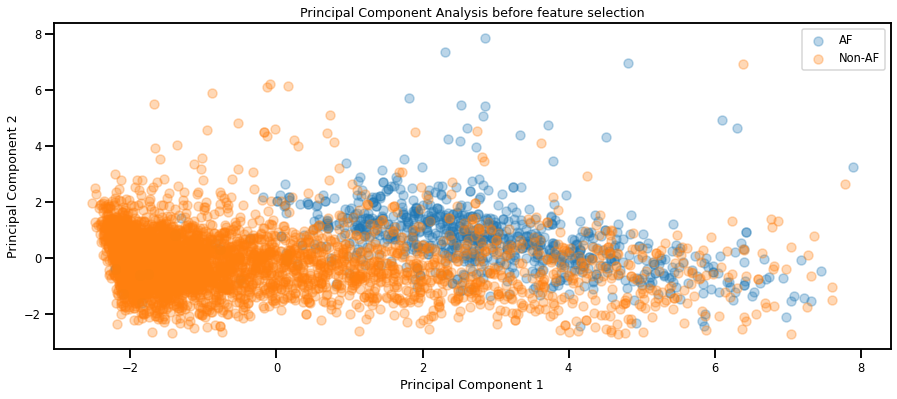

In [21]:
xpca = pd.DataFrame(train_pca)

sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(15,6))
plt.scatter(xpca.loc[(y_train == 1).ravel(),0],xpca.loc[(y_train == 1).ravel(),1], alpha = 0.3, label = 'AF')
plt.scatter(xpca.loc[(y_train == 0).ravel(),0],xpca.loc[(y_train == 0).ravel(),1], alpha = 0.3, label = 'Non-AF')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component Analysis before feature selection')
plt.legend(loc='upper right')
plt.show()

In [22]:
for name, model in models.items():
    scores = cross_val_score(model, train_pca, y_train, cv=4, scoring='roc_auc', n_jobs=4)
    res = res.append({'model': f"{name} PCA", 'auc': scores.mean()}, ignore_index=True)
    
    # Experiment Tracking
    with mlflow.start_run(experiment_id=experiment_id):
        mlflow.log_param("model", f"{name}")
        mlflow.log_param("features", "PCA")
        mlflow.log_param("lead", lead)
        mlflow.log_param("columns", list(X.columns))
        mlflow.log_param("number columns", len(list(X_train.columns)))
        mlflow.log_metric("auc", scores.mean())
        
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        if tracking_url_type_store != "file":

            mlflow.sklearn.log_model(model, "model", registered_model_name="AF_Classifier")
        
        else:
            
            mlflow.sklearn.log_model(model, "model")

In [23]:
res.sort_values('auc', ascending=False)

,model,auc
5,Random Forest Scal,0.982335
9,Random Forest MinMax,0.982335
1,Random Forest,0.982302
6,SVC Scal,0.974193
10,SVC MinMax,0.974193
0,Logistic Regression,0.971947
4,Logistic Regression Scal,0.971881
8,Logistic Regression MinMax,0.971881
13,Random Forest PCA,0.963733
7,KNNeighbors Scal,0.962041
